Purpose: 

In this project, I'm going to introduce you to Computer Vision by covering this following points:
    - How to design from-scratch model for a multi-label classification problem
    - How to use a pre-trained model (as VGG16) to predict ImageNet data classes for new images
    - How to fine-tune a pre-trained model on another dataset to predict new classes

##### Part 1: Tutorial on Binary Classification from-scratch

 0. Environment setup

In [1]:
# 0.0. Install requested libraries
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# --Data
from sklearn.model_selection import train_test_split

# --Model
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping

# --Save logs
from tensorflow.keras.callbacks import TensorBoard

In [2]:
# 0.1. Load dataset
# ** Unzip the data file
with zipfile.ZipFile('./Data/data.zip', 'r') as zip_ref:
    zip_ref.extractall("data")

In [21]:
# **Define paths to data files
data_path = './Data/data'
train_dir = os.path.join(data_path, 'train')
valid_dir = os.path.join(data_path, 'validation')

# **Getting dogs and cats images for training
train_dogs = [os.path.join(train_dir, f).replace('\\', '/') for f in os.listdir(train_dir) if 'dog' in f]
train_cats = [os.path.join(train_dir, f).replace('\\', '/') for f in os.listdir(train_dir) if 'cat' in f]

# **Getting images for training && Shuffling
np.random.seed(0)
train_images = train_dogs + train_cats
np.random.shuffle(train_images)

# **Getting validation images & shuffling
valid_images = [os.path.join(valid_dir, f).replace('\\', '/') for f in os.listdir(valid_dir)]
np.random.shuffle(valid_images)

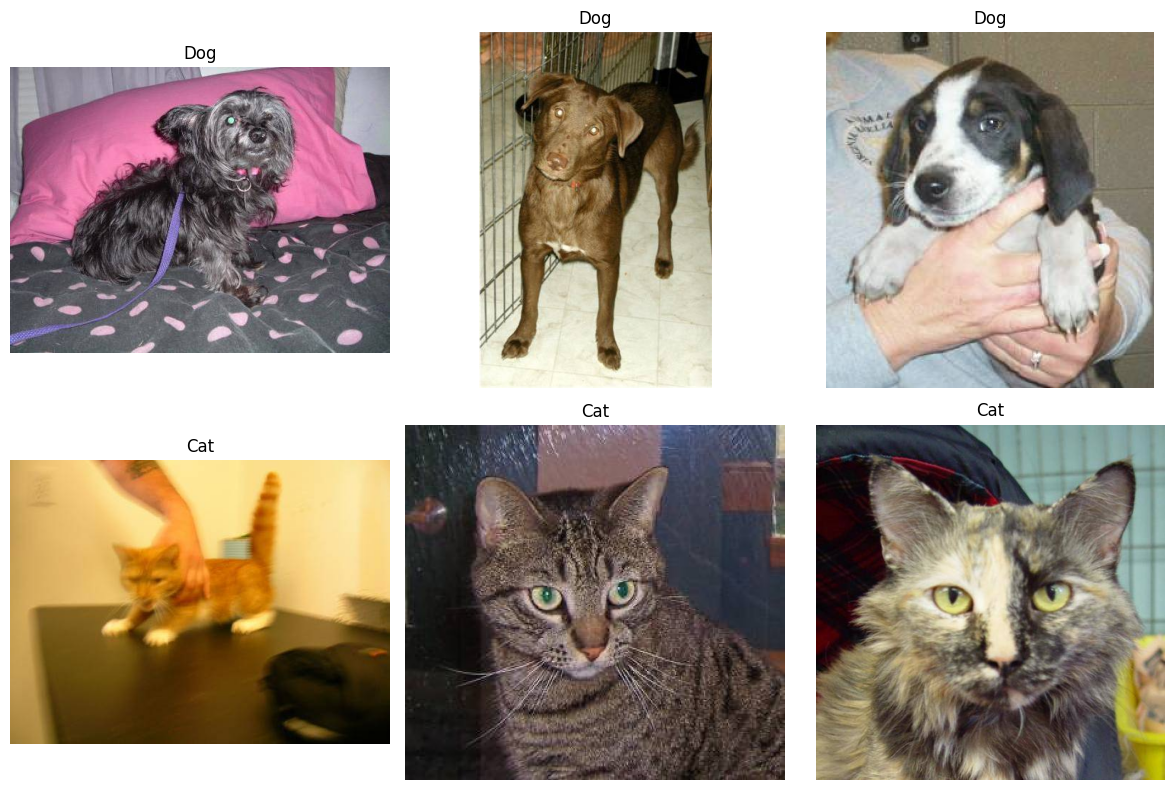

In [4]:
# --Quick check: Display some images

plt.figure(figsize=(12, 8))
for i in range(3):
    img = cv2.imread(train_dogs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Dog')
    plt.axis('off')

for i in range(3):
    img = cv2.imread(train_cats[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, i+4)
    plt.imshow(img)
    plt.title('Cat')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

1. Images Processing

In [26]:

# 1.1. Read and Resize each image
# **Define the function to read and process images
def read_and_process_image(list_of_images):
    X = []
    y = []
    # -- Reading the images and resizing them to 128x128 and converting to RGB
    for image in list_of_images:
        img = cv2.imread(image)
        if img is None:
            print(f"Warning: Unable to read image {image}. Skipping.")
            continue
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)

        # -- Getting labels for the images
        if 'dog' in image:
            y.append(1)  # Label for dog
        else:
            y.append(0)  # Label for cat
    
    X, y = np.array(X), np.array(y)
    return X, y

In [ ]:

# **Apply the function to training images
X, y = read_and_process_image(train_images)

###### Comment: Now, X is an array of our image pixel values and y is a list of label

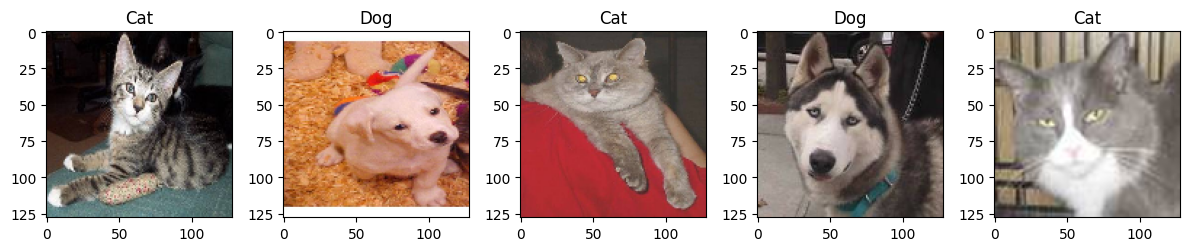

In [7]:
# --Quick check: Display some images

plt.figure(figsize=(12, 8))
for i in range(5):
    img = X[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('Dog' if y[i] == 1 else 'Cat')
plt.tight_layout()
plt.show()

In [8]:
# **Chechk the shape of the data
print(
    f"Train images shape: {X.shape}\n"
    f"Train labels shape: {y.shape}\n"
    f"Number of training images: {len(train_images)}\n"
)

Train images shape: (2048, 128, 128, 3)
Train labels shape: (2048,)
Number of training images: 2048



2. Split data and Modeling

In [9]:
# 2.1. Split the TRAIN data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# --Quick check: Print the shapes of the split data
print(
    f"X_train shape: {X_train.shape}\n"
    f"y_train shape: {y_train.shape}\n"
    f"X_test shape: {X_test.shape}\n"
    f"y_test shape: {y_test.shape}\n"
)

X_train shape: (1638, 128, 128, 3)
y_train shape: (1638,)
X_test shape: (410, 128, 128, 3)
y_test shape: (410,)



In [10]:
# 2.2. Design the CNN model with TensorFlow and Keras
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

# --Display the model architecture
model.summary()

c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Computer-Vision\venvComputerVision\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# GOOD TO KNOW
"""
Note: I'm going to design a model with: 
    - 4 convolutional layers, 
    - each followed by a max pooling layer, and then 
    - flatten the output before passing it to a dense layer for classification.
Being ispired by this paper https://arxiv.org/pdf/1409.1556 , I'll use the same filter sizes that increases from
32 to 64, 128, and 128, 512 with a final dense layer of 1 unit.
--------------------------------------------------------------------------------------------------------------------

Note: 
    - model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        - This line adds a 2D convolutional layer with 32 filters, i.e. the size of the output dimension is 32,
        - each of size 3x3, i.e. Kernel size is (3, 3).
        - using ReLU activation function.
        - The input shape is specified as (128, 128, 3), which means the input images are 128x128 pixels with 3 color channels (RGB).

    - model.add(layers.MaxPooling2D((2, 2)))
        - This line adds a max pooling layer with a pool size of (2, 2), 
        - which reduces the spatial dimensions of the output from the previous convolutional layer by half.
        - It helps to down-sample the feature maps and reduce the number of parameters in the model.
        - That reduces the computational cost and helps to prevent overfitting.
    
    - model.add(layers.Flatten())
        - This line flattens the output from the previous layer into a 1D vector, 
        - which is necessary before passing it to the dense layers.
    
    - model.add(layers.Dropout(0.5))
        - This line adds a dropout layer with a dropout rate of 0.5, 
        - which randomly sets 50% of the input units to 0 during training. The, learns with the reduced network.
        - This way, the network learns to be independent and not reliable on a single layer
        - It helps to prevent overfitting by reducing the reliance on specific neurons.
        
    - model.add(layers.Dense(512, activation='relu'))
        - This line adds a fully connected (dense) layer with 512 units and ReLU activation function.
        - It allows the model to learn complex representations of the input data.
    
    - model.add(layers.Dense(1, activation='sigmoid'))
        - This line adds the output layer with 1 unit and a sigmoid activation function, 
        - which is suitable for binary classification tasks (e.g., distinguishing between cats and dogs).
"""

"\nNote: I'm going to design a model with: \n    - 4 convolutional layers, \n    - each followed by a max pooling layer, and then \n    - flatten the output before passing it to a dense layer for classification.\nBeing ispired by this paper https://arxiv.org/pdf/1409.1556 , I'll use the same filter sizes that increases from\n32 to 64, 128, and 128, 512 with a final dense layer of 1 unit.\n--------------------------------------------------------------------------------------------------------------------\n\nNote: \n    - model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))\n        - This line adds a 2D convolutional layer with 32 filters, i.e. the size of the output dimension is 32,\n        - each of size 3x3, i.e. Kernel size is (3, 3).\n        - using ReLU activation function.\n        - The input shape is specified as (128, 128, 3), which means the input images are 128x128 pixels with 3 color channels (RGB).\n\n    - model.add(layers.MaxPooling2D((2, 

In [12]:
# ** Compile the model
"""Note: Because this is a binary classification problem, I'm going to use the 'binary_crossentropy' loss function."""
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
# 2.3. Data augmentation
"""
Note: Due to the fact that the dataset is small, I'm going to use data augmentation to increase the diversity of the training data.
        Also, rotate same images, shift them, zoom in and out, shear them, and flip them horizontally, all that to be more robust and 
        near to real-world scenarios.
"""
# ** Create ImageDataGenerator for training and validation sets
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

# **Generating batches of augmented data from X and y by applying the transformations defined above
"""Note: Each batch will contain batch_size images and their corresponding labels."""
batch_size = 32

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

In [14]:
# 2.4. Train the model and save trained_logs
"""Note: Let us save the trained model in a file 'logs/CNN_FromScratch' with TensorBoard from Keras."""

NAME = "CNN_FromScratch"
tensorboard = TensorBoard(log_dir=f"logs/{NAME}")

steps_per_epoch = len(X_train) // batch_size
test_steps = len(X_test) // batch_size

# --Let us stop the model training once the validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# ** Train the model with TensorBoard callback
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    validation_data=test_generator,
    validation_steps=test_steps,
    callbacks=[tensorboard]
)

c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Computer-Vision\venvComputerVision\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.5118 - loss: 1.6053 - val_accuracy: 0.5182 - val_loss: 1.5671
Epoch 2/60
 1/51 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.4688 - loss: 1.5742

c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Computer-Vision\venvComputerVision\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4688 - loss: 1.5742 - val_accuracy: 0.5000 - val_loss: 1.5619
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - accuracy: 0.5460 - loss: 1.5478 - val_accuracy: 0.5026 - val_loss: 1.5088
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5938 - loss: 1.4876 - val_accuracy: 0.4922 - val_loss: 1.5127
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.5582 - loss: 1.4926 - val_accuracy: 0.5599 - val_loss: 1.4581
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5625 - loss: 1.4771 - val_accuracy: 0.5625 - val_loss: 1.4555
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.5849 - loss: 1.4409 - val_accuracy: 0.5104 - val_loss: 1.4282
Epoch 8/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6250 - loss: 1.3957 - val_accuracy: 0.5781 - val_loss: 1.4025
Epoch 9/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.5785 - loss: 1.3933 - val_accuracy: 0.6276 - val_

In [15]:
# 2.5. Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7807 - loss: 0.7730


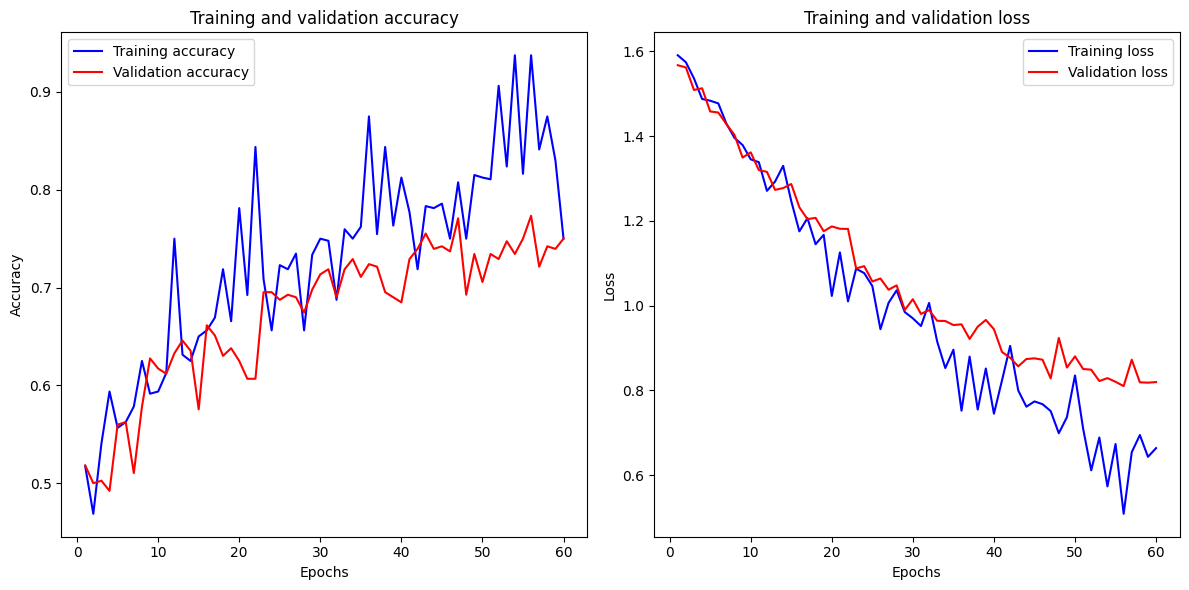

In [16]:
# **Display the accuracy and loss on graphs
accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Comment my graphs
"""
It seems that the model is overfitting and here are my reasons:
    - The validation accuracy despite the fact that it is encreasing, but it shows a fluctuation and a decrease ==> The model
        is not generalizing well to the validation data.
    - The validation loss is not decreasing as expected, and it is fluctuating, which indicates that the model is not learning well from the validation data.
    
Therefore, I change the optimizer from 'Adam' to 'RMSprop' with a learning rate of 1e-4, and I added a dropout layer with a rate of 0.5 to reduce overfitting.
and the model is better.
"""

'\nIt seems that the model is overfitting and here are my reasons:\n    - The validation accuracy despite the fact that it is encreasing, but it shows a fluctuation and a decrease ==> The model\n        is not generalizing well to the validation data.\n    - The validation loss is not decreasing as expected, and it is fluctuating, which indicates that the model is not learning well from the validation data.\n'

In [18]:
# 2.5. Save the model
model.save_weights('models_CNN_from_scratch.weights.h5')
model.save('models_CNN_from_scratch.h5')


In [28]:
# 2.6. Validate the model on the validation set
X_val, y_val = read_and_process_image(valid_images)
valid_generator = test_datagen.flow(X_val, y_val, batch_size=batch_size)
valid_loss, valid_accuracy = model.evaluate(valid_generator, steps=len(X_val) // batch_size)
print(f"Validation Loss: {round(valid_loss, 4)}, Validation Accuracy: {round(valid_accuracy, 4)}")


 1/26 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7188 - loss: 0.7890

c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Computer-Vision\venvComputerVision\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7325 - loss: 0.8009
Validation Loss: 0.8071, Validation Accuracy: 0.7392


4. Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


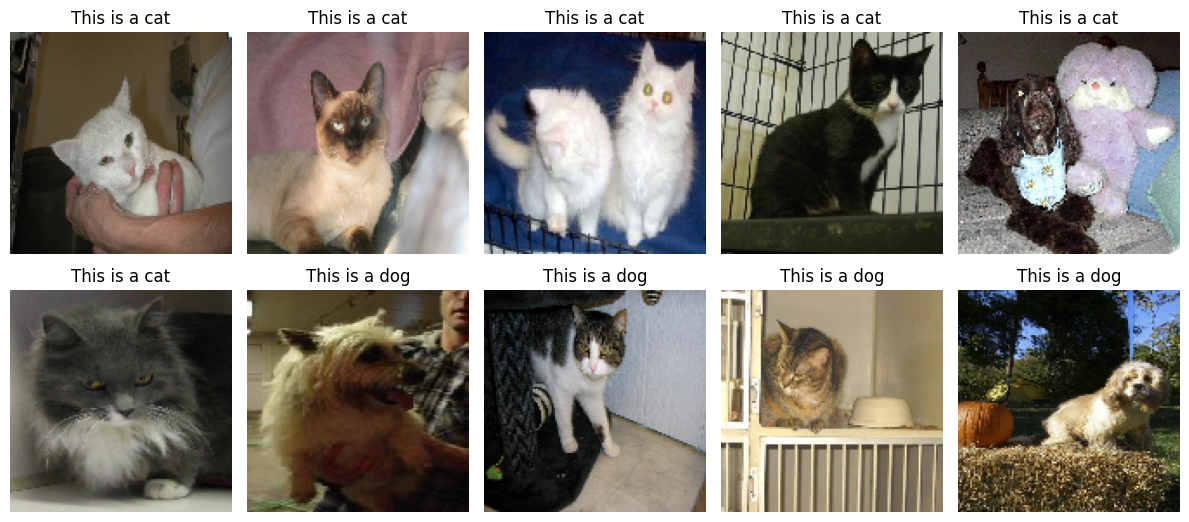

In [ ]:
# Prédiction et affichage sur 10 images du set de validation

columns = 5 
plt.figure(figsize=(12, 8))
text_labels = []

for i in range(10):
    image_path = valid_images[i]
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0 

    pred = model.predict(img_array)
    if pred[0][0] > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')

    plt.subplot((10 // columns) + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()